# Opstellen eigen convolutioneel neuraal netwerk

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

# importeren van zelf geschreven modules
from Callbacks.RealTimePlotCallback import RealTimePlotCallback
from dataset_module import dataset_creation

In [8]:
# garanderen dat ik in de correcte working directory bezig ben
while os.getcwd() != "C:\\My Projects\\Opdracht-schilders":
    os.chdir('..')

os.chdir('4. Eigen Modellen/4.1 Eigen Convolutioneel Netwerk')
os.getcwd()

'C:\\My Projects\\Opdracht-schilders\\4. Eigen Modellen\\4.1 Eigen Convolutioneel Netwerk'

## Inlezen data

In [9]:
classes = os.listdir("../../datasets/paintings")

In [14]:
(train_data, train_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/train/")
(val_data, val_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/validation")
(test_data, test_labels) = dataset_creation.create_data_with_labels("../../datasets/dataset/test")

..\..\datasets\dataset\train\Picasso\150.jpg --> FAILED
..\..\datasets\dataset\test\Picasso\1502.jpg --> FAILED


## Opstellen Convolutioneel Neuraal Netwerk (CNN)

In deze notebook zal ik (vooraleer ik met transferlearning aan de slag ga) een eigen convolutioneel model opstellen. Ik zal gebruik maken van een Hold-Out Validation en zal me baseren op de accuracy & loss metrieken.

### Begin model

Hieronder vindt u het model die ik opgestelt heb en zal gebruiken als uitgangspunt.

- 3 convolutionele lagen met respectievelijk 32, 64 en 128 filters. Deze lagen worden telkens gevolgd door een MaxPooling2D laag.
- Als activatiefunctie gebruik ik softmax, omdat we te maken hebben met multiclass single-label classification.
- Ik maak gebruik van de sparse_categorical_crossentropy loss-functie voor dezelfde reden.
- Als optimizer gebruik ik RMSprop().

In [5]:
input_layer = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(input_layer)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x)  # 5 because we have 5 classes (0 through 4)

model = keras.Model(inputs=input_layer, outputs=outputs)

# Return the compiled model
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.RMSprop(),
  metrics=["accuracy"],
)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

<Figure size 640x480 with 0 Axes>

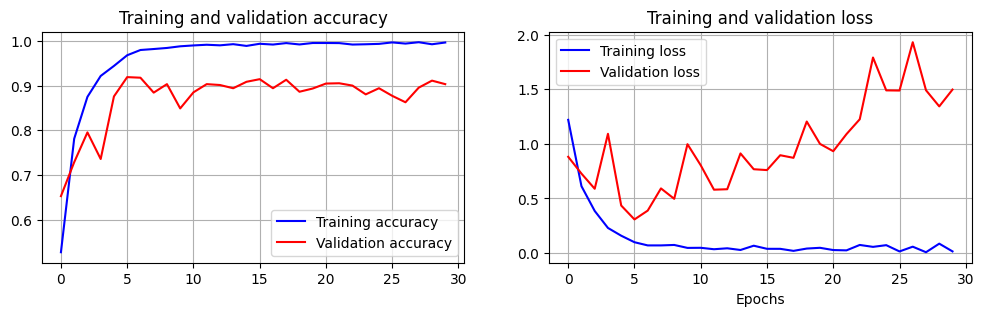

training loss: 0.014721940271556377
validation loss: 1.4964479207992554
training accuracy: 0.9969492554664612
validation accuracy: 0.9036065340042114

epochs: 30

144/144 [==============================] - 5s 34ms/step - loss: 0.0147 - accuracy: 0.9969 - val_loss: 1.4964 - val_accuracy: 0.9036


In [7]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="eigen_CNN.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     RealTimePlotCallback()
]

history = model.fit(
    train_data, train_labels,
    batch_size=32,
    epochs=30,
    validation_data=(val_data, val_labels),
    callbacks=callbacks_list
)

We zien op de grafiek van de loss dat ons model na 5 epochs overfit (de loss begint omhoog te gaan, de accuracy gaat ook niet meer omhoog). Ik zal dit aanpakken door in de volgende stap gebruik te maken van **data augmentation**.

In [8]:
model = keras.models.load_model('eigen_CNN.keras')
model.evaluate(test_data, test_labels)

48/48 [==============================] - 1s 16ms/step - loss: 0.3953 - accuracy: 0.9065


[0.3953491449356079, 0.9064748287200928]

Wanneer we ons 'best saved model' (de we via de ModelCheckpoint callback bekomen) laden, zien we dat we en **accuracy van 91%** hebben en een **loss van 0.40** op de testdata.

48/48 [==============================] - 1s 9ms/step


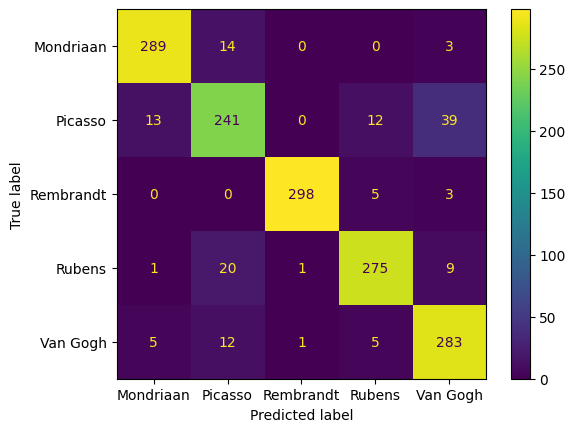

In [9]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Er zijn volgens mij niet meteen enige belangrijke bevindingen te zien op de confusion matrix. We zien wel dat het model:
- Picasso soms verward met Van Gogh.

## Eigen CNN met data augmentation

Hieronder ziet u op de afbeelding de 10 verschillende layers die gebruikt kunnen worden voor data augmentation.
Ik kies voor:
- RandomFlip
- RandomRotation
- RandomZoom

Ik zal geen gebruik maken van de andere omdat:
- RandomBrightness: De helderheid van de gebruikte verfkleur kan een identificerende factor zijn om de juiste schilder te voorspellen
- RandomContrast: zelfde reden als RandomBrightness
- RandomCrop: Ik zal de gehele image gebruiken
- RandomHeight & RandomWidth: Ik werk met batches en en een 3D tensor. Volgens de [documentatie](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomHeight#:~:text=The%20input%20should%20be%20a%203D%20(unbatched)) van deze layer moet je om deze layer te gebruiken met unbatched 3D tensors gebruiken.

![alt text](data%20augmentation%20layers.JPG "Data augmentation layers")

Ik gebruik hetzelfde model als in de vorige stap, maar nu met data augmentation.

In [13]:
data_augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.3),
            layers.RandomZoom(0.2),
        ]
    )

input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x)  # 5 because we have 5 classes (0 through 4)

model = keras.Model(inputs=input_layer, outputs=outputs)

# Return the compiled model
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.RMSprop(),
  metrics=["accuracy"],
)

In [14]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

<Figure size 640x480 with 0 Axes>

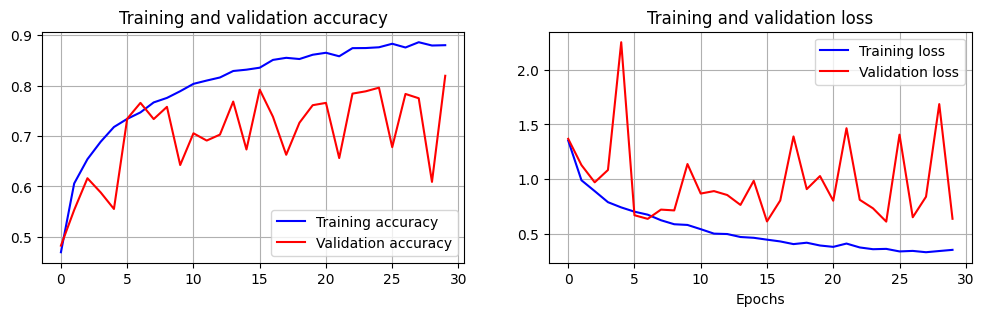

training loss: 0.35796141624450684
validation loss: 0.6408758759498596
training accuracy: 0.8803660869598389
validation accuracy: 0.8196721076965332

epochs: 30

144/144 [==============================] - 51s 354ms/step - loss: 0.3580 - accuracy: 0.8804 - val_loss: 0.6409 - val_accuracy: 0.8197


In [15]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="eigen_CNN_data_augmentation.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     RealTimePlotCallback()
]

history = model.fit(
    train_data, train_labels,
    batch_size=32,
    epochs=30,
    validation_data=(val_data, val_labels),
    callbacks=callbacks_list
)

In [16]:
model = keras.models.load_model('eigen_CNN_data_augmentation.keras')
model.evaluate(test_data, test_labels)

48/48 [==============================] - 1s 11ms/step - loss: 0.5999 - accuracy: 0.8005


[0.5998905301094055, 0.8005232214927673]

48/48 [==============================] - 1s 9ms/step


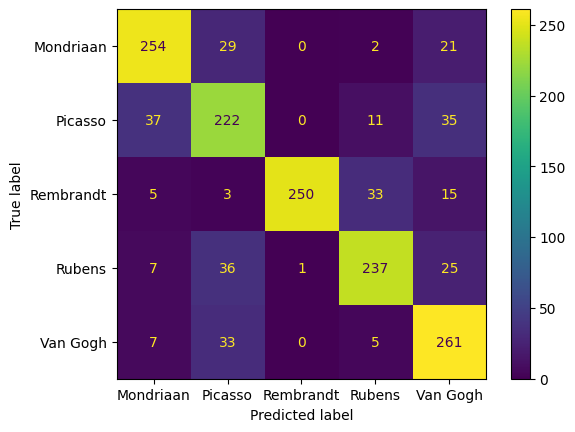

In [17]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(model.predict(test_data), axis=-1))
ConfusionMatrixDisplay(cm, display_labels=classes).plot()
plt.show()

Op de confusion matrix zien we veel verwarring tussen de verschillende schilders.

In [18]:
model.evaluate(test_data, test_labels)

48/48 [==============================] - 1s 11ms/step - loss: 0.5999 - accuracy: 0.8005


[0.5998905301094055, 0.8005232214927673]

Ik bekom slechtere resultaten dan de resultaten zonder data augmentation.
De volgende stap die ik zou nemen is dat ik wat dropout layers zou toevoegen en zien welke resulaten ik hiermee krijg.

## Overstap naar transferlearning

Ik heb besloten om over te stappen naar transferlearning. Daar zal ik hoogstwaarschijnlijk toch betere resultaten bekomen, dus lijkt het me nuttiger om me daar meer op te focussen dan op een eigen model.
(Ik zag ook dat er geen punten stonden op een eigen model maken, maar wel op transferlearning)